In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)
print('Location:', torch.__file__) # /home/emre/.local/lib/python3.7/site-packages

1.12.0+cu102
True
10.2
Location: /home/emre/anaconda3/envs/emre_venv/lib/python3.9/site-packages/torch/__init__.py


/home/emre/anaconda3/envs/emre_venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from typing import Union, Tuple
from torch_geometric.typing import OptPairTensor, Adj, Size # Optional[Tensor], Union[Tensor, SparseTensor], Optional[Tuple[int, int]], all about data type

from torch import Tensor
from torch.nn import Linear
import torch.nn.functional as F
from torch_sparse import SparseTensor, matmul
from torch_geometric.nn.conv import MessagePassing

In [3]:
import warnings
warnings.filterwarnings("ignore")
from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.nn.functional as F
import torch_geometric.nn as gnn
import torch.nn as nn
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Dataset, Data, DataLoader
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.utils import softmax

In [4]:
import pickle
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' 

In [5]:
def load_pkl(filename):
    with open(filename, 'rb') as input:
        data = pickle.load(input)
    return data

In [6]:
[train_images, train_vids, train_skels, train_labels,
 test_images, test_vids, test_skels, test_labels] = load_pkl('/mnt/HDD04/ICASSP_2023/Scripts/datasets/ASL_10_vid_skel_mDsim.pkl')
train_labels = np.argmax(train_labels, -1)
test_labels = np.argmax(test_labels, -1)

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(210, 128, 128, 3)
(210,)
(55, 128, 128, 3)
(55,)


In [7]:
max_seq_len = np.max([len(t) for t in test_vids])
print('max_seq_len:', max_seq_len)

max_seq_len: 114


In [8]:

for idx, t in enumerate(train_vids):
    num_pad = max_seq_len - len(t)
    if num_pad != 0:
        last_frame = np.expand_dims(t[-1], 0)
        train_vids[idx] = np.concatenate([t, np.tile(last_frame, [num_pad, 1, 1, 1])])
train_vids = np.array(list(train_vids)) 
train_vids = np.swapaxes(train_vids.astype(np.float64), 1, -1)
# train_vids = train_vids.reshape(train_vids.shape[0], train_vids.shape[1],
#                                 train_vids.shape[2], train_vids.shape[3]*train_vids.shape[4])
# [batch_size, channels, height, width, depth].
print(train_vids.shape)

for idx, t in enumerate(test_vids):
    num_pad = max_seq_len - len(t)
    if num_pad != 0:
        last_frame = np.expand_dims(t[-1], 0)
        test_vids[idx] = np.concatenate([t, np.tile(last_frame, [num_pad, 1, 1, 1])])
test_vids = np.array(list(test_vids))
test_vids = np.swapaxes(test_vids.astype(np.float64), 1, -1)
# test_vids = test_vids.reshape(test_vids.shape[0], test_vids.shape[1],
#                               test_vids.shape[2], test_vids.shape[3]*test_vids.shape[4])
print(test_vids.shape)

(210, 3, 128, 128, 114)
(55, 3, 128, 128, 114)


## Dataloader

In [9]:
class CustomImageDataset(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        temp_x = torch.tensor(self.x[idx], dtype=torch.float)
        temp_y = torch.tensor(self.y[idx], dtype=torch.long)
#         self.x = self.x[idx]
#         self.y = self.y[idx]
#         return self.x[idx], self.y[idx] 
        return temp_x, temp_y

In [10]:
batch_size = 4
training_data = CustomImageDataset(torch.from_numpy(train_vids), torch.from_numpy(train_labels))
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, collate_fn=lambda x: x)
testing_data = CustomImageDataset(torch.from_numpy(test_vids), torch.from_numpy(test_labels))
test_loader = DataLoader(testing_data, batch_size=batch_size, shuffle=True, collate_fn=lambda x: x)
training_features, training_labels = next(iter(train_loader))
print(f"Feature batch shape: {training_features.size()}")
print(f"Labels batch shape: {training_labels.size()}")

Feature batch shape: torch.Size([4, 3, 128, 128, 114])
Labels batch shape: torch.Size([4])


## Train Func

In [11]:
def train( model, model_name, prog_bar = True):
    
    max_test_acc = 0.0
    train_accs = []
    test_accs = []
    
    for epoch in range(epochs):
        train_acc = []
        test_acc = []
        if prog_bar:
            pbar = tqdm(train_loader,position=0)
        else:
            pbar = train_loader
            
        # train
        for data in pbar:
            x, labels = data
            x = x.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            preds = np.argmax(out.cpu().detach().numpy(), -1)
            labels = labels.cpu().detach().numpy()
            acc = np.sum(preds == labels) / len(labels) * 100
            train_acc.append(acc)
            if prog_bar:
                pbar.set_description('Train_acc: '+str(round(acc,2)))
        train_accs.append(np.mean(train_acc))
        
        # test
        all_preds = []
        for data in test_loader:
            x, labels = data
            x = x.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, labels)
            preds = np.argmax(out.cpu().detach().numpy(), -1)
            labels = labels.cpu().detach().numpy()
            acc = np.sum(preds == labels) / len(labels) * 100
            test_acc.append(acc)
            all_preds.append(preds)
        test_accs.append(np.mean(test_acc))
        
        if np.mean(test_acc) > max_test_acc:
#             print(np.array(all_preds[0]).shape)
#             print(np.array(all_preds[1]).shape)
            best_preds = [i for a in all_preds for i in a]
            max_test_acc = np.mean(test_acc)
            torch.save(model.state_dict(), '../models/' + model_name + str(round(max_test_acc, 2)) + '.pth')
        
#         lr_scheduler.step(test_loss)
        print('Epoch: ', str(epoch+1)+'/'+str(epochs),'| Training Acc: ', round(np.mean(train_acc), 2), '| Testing Acc: ', round(np.mean(test_acc), 2))
#         train_losses.append(train_loss)
#         test_losses.append(test_loss)

        
        if not prog_bar:
            clear_output(wait=True)
            print('Epoch: ', str(epoch+1)+'/'+str(epochs),'| Training Acc: ', round(np.mean(train_acc), 2), '| Testing Acc: ', round(np.mean(test_acc), 2),
                 ', Best Testing Acc:', max_test_acc)
            plt.plot(train_accs, label="Train Acc")
            plt.plot(test_accs, label="Validation Acc")
            plt.xlabel("# Epoch")
            plt.ylabel("Accuracy")
            plt.legend(loc='upper right')
            plt.show()
    return best_preds

## 3D CNN

In [12]:
class CNN3D(nn.Module):
    def __init__(self):
        super().__init__()
        # 2D
#         self.conv = nn.Sequential(nn.Conv2d(3, 32, 3),
#                                   nn.MaxPool2d(2, 2),
                                  
#                                   nn.Conv2d(32, 64, 3),
#                                   nn.MaxPool2d(2, 2),
                                  
#                                   nn.Conv2d(64, 128, 3),
#                                   nn.MaxPool2d(2, 2)
#                                   )
        
                                  
#         self.fc = nn.Sequential(nn.Linear(14*128*2446, 16),
#                                 nn.Dropout(0.5),
                                
#                                 nn.Linear(16, 10)
#                                )
        
        self.conv = nn.Sequential(nn.Conv3d(3, 32, 3),
                                  nn.ReLU(),
                                  nn.MaxPool3d((2, 2, 1)),
                                  
                                  nn.Conv3d(32, 64, 3),
                                  nn.ReLU(),
                                  nn.MaxPool3d((2, 2, 1)),
                                  
                                  nn.Conv3d(64, 128, 3),
                                  nn.ReLU(),
                                  nn.MaxPool3d((2, 2, 1)),
                                  
                                  nn.Conv3d(128, 128, 3),
                                  nn.ReLU(),
                                  nn.MaxPool3d((2, 2, 1))
                                  )
        
                                  
        self.fc = nn.Sequential(nn.LSTM(32, 256, num_layers=1),
                                
                                nn.Linear(256, 128),
                                nn.ReLU(),
#                                 nn.Dropout(0.5),
                                
                                nn.Linear(128, 64),
                                nn.ReLU(),
#                                 nn.Dropout(0.5),
                                
                                nn.Linear(64, 10)
                               )
        
#         self.pool = nn.MaxPool3d(2, 2)
#         self.conv2 = nn.Conv3d(32, 64, 3)
#         self.conv3 = nn.Conv3d(64, 64, 3)
        self.lstm = nn.LSTM(106, 128, num_layers=2)
        self.fc1 = nn.Linear(589824, 16) # 3 layers: 14*14*128, 4 layers: 6*6*128
#         self.fc2 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(16, 10)
        self.drop = nn.Dropout(0.5)

    def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
#         x = self.pool(F.relu(self.conv4(x)))
        x = self.conv(x)
        x = torch.flatten(x, 1, -2) # flatten all dimensions except batch
#         x = x.view()
#         x = F.relu(self.fc1(x))
#         x = self.fc(x)
#         x = self.drop(x)
        x, hidden = self.lstm(x)
        x = F.relu(self.fc1(torch.flatten(x, 1)))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
#         x = F.relu(self.fc2(x))
#         x = self.drop(x)
        x = F.softmax(x)
        return x

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(2)
model = CNN3D().to(device)
# summary(model, (3, 128, 128, max_seq_len))
print('device:', device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device: cuda


Epoch:  500/500 | Training Acc:  8.96 | Testing Acc:  24.4 , Best Testing Acc: 25.595238095238095


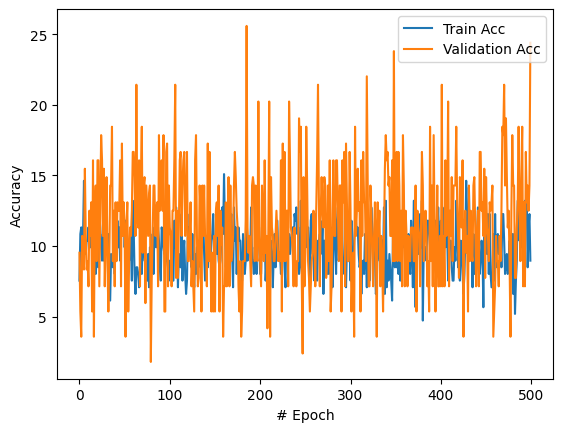

In [15]:
model_name = 'model_cnn3d_vid_acc'
epochs = 500
best_preds = train(model, model_name, prog_bar = False)

# Time Distributed CNN

In [12]:
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=True):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):
        
        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
#         x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)
        x_reshape = x.contiguous().view(x.size(0), x.size(1), -1, x.size(-1))  # (samples, timesteps, input_size)
        
#         print(x_reshape.shape)
        y = self.module(x_reshape)
#         print(y.shape)
        sqrt_dim = int(np.floor(y.shape[2]**0.5))

        # We have to reshape Y
        if self.batch_first:
#             y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
            y = y[:, :, :sqrt_dim**2, :].contiguous().view(x.size(0), y.size(1), sqrt_dim, sqrt_dim, y.size(-1))  # (samples, channels, output_size, timesteps)
        else:
            pass
#             y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size
#         print(y.shape)
#         print('end td')
        return y

In [13]:
class TD_CNN2D(nn.Module):
    def __init__(self):
        super().__init__()
        # 2D
#         self.conv = nn.Sequential(TimeDistributed(nn.Conv2d(3, 32, 3)),
#                                   TimeDistributed(nn.MaxPool2d(2, 2)),
                                  
#                                   TimeDistributed(nn.Conv2d(32, 64, 3)),
#                                   TimeDistributed(nn.MaxPool2d(2, 2)),
                                  
#                                   TimeDistributed(nn.Conv2d(64, 128, 3)),
#                                   TimeDistributed(nn.MaxPool2d(2, 2))
#                  
        self.conv1 = TimeDistributed(nn.Conv2d(3, 32, 3))
        self.conv2 = TimeDistributed(nn.Conv2d(32, 64, 3))
        self.conv3 = TimeDistributed(nn.Conv2d(64, 128, 3))
        self.pool = nn.MaxPool3d((2, 2, 1))
        
        self.lstm = nn.LSTM(108, 128, num_layers=2)
        self.fc1 = nn.Linear(3686400, 16) # 3 layers: 14*14*128, 4 layers: 6*6*128
#         self.fc2 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(16, 10)
        self.drop = nn.Dropout(0.5)

    def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.td(x)
        x = self.pool(F.relu(self.conv1(x)))
#         print('x:', x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
#         x = self.pool(F.relu(self.conv4(x)))
#         x = self.conv(x)
        x = torch.flatten(x, 1, -2) # flatten all dimensions except batch
#         x = x.view()
#         x = F.relu(self.fc1(x))
#         x = self.fc(x)
#         x = self.drop(x)
        x, hidden = self.lstm(x)
        x = F.relu(self.fc1(torch.flatten(x, 1)))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
#         x = F.relu(self.fc2(x))
#         x = self.drop(x)
        x = F.softmax(x)
        return x

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(2)
model = TD_CNN2D().to(device)
# summary(model, (3, 128, 128, max_seq_len))
print('device:', device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device: cuda


Epoch:  500/500 | Training Acc:  10.38 | Testing Acc:  14.29 , Best Testing Acc: 22.619047619047617


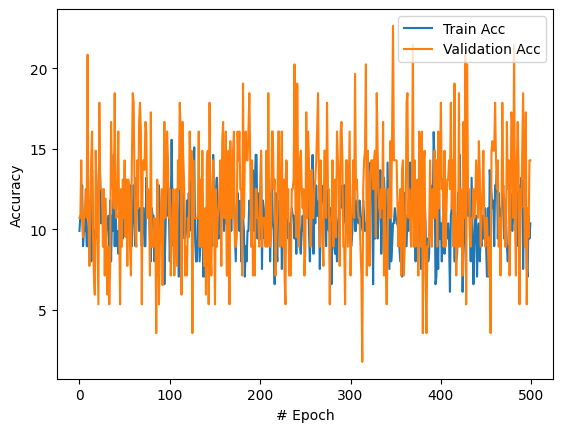

In [15]:
model_name = 'model_tdcnn2d_vid_acc'
epochs = 500
best_preds = train(model, model_name, prog_bar = False)